In [1]:
!nvidia-smi

Sun Nov 14 14:54:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!pip install import-ipynb
!pip install albumentations==0.4.6
#!pip install -U efficientnet==0.0.4
#!git clone https://github.com/qubvel/efficientnet.git
#!pip install -U efficientnet
!pip install -U --pre efficientnet
!pip install tfa-nightly
!pip install tensorflow-addons

In [4]:
import sys
import os
import glob
from PIL import Image
from IPython.display import clear_output
import math
import random
import scipy.io as sio
import re
import time
from tensorflow.keras import models,layers
from tensorflow.keras.utils import get_file
from collections import namedtuple
from tqdm import tqdm, tqdm_notebook
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid
%matplotlib inline
import seaborn as sns
import zipfile
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras.layers.experimental import preprocessing
from IPython.display import display
from efficientnet.keras import *

%cd /content/drive/MyDrive/brain_mri_segmentation/PRANet-Polyps-Segmentation/
from model.ra_module import ReverseAttention
from model.partial_decoder import PartialDecoder
from model.rfb import RFB
from model.backbone import FE_backbone

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


/content/drive/.shortcut-targets-by-id/1w-TuKfFg1p_kmorgOYNhTF-HPfPcx4Ab/brain_mri_segmentation/PRANet-Polyps-Segmentation


In [5]:
#%run /content/drive/MyDrive/Pix2Pix-for-Semantic-Segmentation-of-Satellite-Images/UnetModel1.ipynb
# %run MumfordLoss.ipynb
%run /content/drive/MyDrive/Pix2Pix-for-Semantic-Segmentation-of-Satellite-Images/augmentation.ipynb

# Segmentation Training

## Preparation

In [6]:
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn

In [7]:
def up_and_concate(down_layer, layer, data_format='channels_last'):
    data_format='channels_last'
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])

    return concate
def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    data_format='channels_last'
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate
def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    data_format='channels_last'
    # theta_x(?,g_height,g_width,inter_channel)

    print(x.shape)
    print(g.shape)

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)
    print(theta_x.shape)

    # phi_g(?,g_height,g_width,inter_channel)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)
    print(phi_g.shape)

    # f(?,g_height,g_width,inter_channel)

    f = Activation('relu')(add([theta_x, phi_g]))

    # psi_f(?,g_height,g_width,1)

    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    # rate(?,x_height,x_width)

    # att_x(?,x_height,x_width,x_channel)

    att_x = multiply([x, rate])

    return att_x
def res_block(input_layer, out_n_filters, batch_normalization=False, kernel_size=[3, 3], stride=[1, 1],

              padding='same', data_format='channels_first'):
    data_format='channels_last'
    if data_format == 'channels_first':
        input_n_filters = input_layer.get_shape().as_list()[1]
    else:
        input_n_filters = input_layer.get_shape().as_list()[3]

    layer = input_layer
    for i in range(2):
        layer = Conv2D(out_n_filters // 4, [1, 1], strides=stride, padding=padding, data_format=data_format)(layer)
        if batch_normalization:
            layer = BatchNormalization()(layer)
        layer = Activation('relu')(layer)
        layer = Conv2D(out_n_filters // 4, kernel_size, strides=stride, padding=padding, data_format=data_format)(layer)
        layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding, data_format=data_format)(layer)

    if out_n_filters != input_n_filters:
        skip_layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding, data_format=data_format)(
            input_layer)
    else:
        skip_layer = input_layer
    out_layer = add([layer, skip_layer])
    return out_layer


# Recurrent Residual Convolutional Neural Network based on U-Net (R2U-Net)
def rec_res_block(input_layer, out_n_filters, batch_normalization=False, kernel_size=[3, 3], stride=[1, 1],

                  padding='same', data_format='channels_first'):
    data_format='channels_last'
    if data_format == 'channels_first':
        input_n_filters = input_layer.get_shape().as_list()[1]
    else:
        input_n_filters = input_layer.get_shape().as_list()[3]

    if out_n_filters != input_n_filters:
        skip_layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding, data_format=data_format)(
            input_layer)
    else:
        skip_layer = input_layer

    layer = skip_layer
    for j in range(2):

        for i in range(2):
            if i == 0:

                layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding, data_format=data_format)(
                    layer)
                if batch_normalization:
                    layer1 = BatchNormalization()(layer1)
                layer1 = Activation('relu')(layer1)
            layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding, data_format=data_format)(
                add([layer1, layer]))
            if batch_normalization:
                layer1 = BatchNormalization()(layer1)
            layer1 = Activation('relu')(layer1)
        layer = layer1

    out_layer = add([layer, skip_layer])
    return out_layer

In [8]:
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same",use_bias=False,kernel_initializer='he_normal')(y1)
    y1 = Lambda(mvn)(y1)
    y1 = ReLU()(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False,kernel_initializer='he_normal')(x)
    y2 = Lambda(mvn)(y2)
    y2 = ReLU()(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False,kernel_initializer='he_normal')(x)
    y3 = Lambda(mvn)(y3)
    y3 = ReLU()(y3)

    y4 = Conv2D(filter, 5, dilation_rate=12, padding="same", use_bias=False,kernel_initializer='he_normal')(x)
    y4 = Lambda(mvn)(y4)
    y4 = ReLU()(y4)

    y5 = Conv2D(filter, 7, dilation_rate=18, padding="same", use_bias=False,kernel_initializer='he_normal')(x)
    y5 = Lambda(mvn)(y5)
    y5 = ReLU()(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False,kernel_initializer='he_normal')(y)
    y = Lambda(mvn)(y)
    y = ReLU()(y)
    return y

In [9]:
def refinement_module(x, input_filter, middle_filter):
  hx = x
  hx0 = Conv2D(middle_filter*1, 3, padding="same", use_bias=False,kernel_initializer='he_normal')(hx)
  #print(hx0.shape)

  hx1 = Conv2D(middle_filter*1, 3, padding="same", use_bias=False,kernel_initializer='he_normal')(hx0)
  hx1 = Lambda(mvn)(hx1)
  hx1 = ReLU()(hx1)
  hx1 = MaxPooling2D(strides=(2,2))(hx1)
  #print(hx1.shape)

  hx2 = Conv2D(middle_filter*1, 3, padding="same", use_bias=False,kernel_initializer='he_normal')(hx1)
  hx2 = Lambda(mvn)(hx2)
  hx2 = ReLU()(hx2)
  hx2 = MaxPooling2D(strides=(2,2))(hx2)
  #print(hx2.shape)

  hx3 = Conv2D(middle_filter*1, 3, padding="same", use_bias=False,kernel_initializer='he_normal')(hx2)
  hx3 = Lambda(mvn)(hx3)
  hx3 = ReLU()(hx3)
  hx3 = MaxPooling2D(strides=(2,2))(hx3)
  #print(hx3.shape)

  hx4 = Conv2D(middle_filter*1, 3, padding="same", use_bias=False,kernel_initializer='he_normal')(hx3)
  hx4 = Lambda(mvn)(hx4)
  hx4 = ReLU()(hx4)
  hx4 = MaxPooling2D(strides=(2,2))(hx4)
  #print(hx4.shape)

  hx5 = Conv2D(middle_filter*1, 3, padding="same", use_bias=False,kernel_initializer='he_normal')(hx4)
  hx5 = Lambda(mvn)(hx5)
  hx5 = ReLU()(hx5)
  #print(hx5.shape)
  hx5 = UpSampling2D(size=(2,2), interpolation='bilinear')(hx5)
  #print(hx5.shape)

  hx6 = Concatenate()([hx5, hx3])
  hx6 = Conv2D(middle_filter*1, 3, padding="same", use_bias=False,kernel_initializer='he_normal')(hx6)
  hx6 = Lambda(mvn)(hx6)
  hx6 = ReLU()(hx6)
  hx6 = UpSampling2D(size=(2,2), interpolation='bilinear')(hx6)

  hx7 = Concatenate()([hx6, hx2])
  hx7 = Conv2D(middle_filter*1, 3, padding="same", use_bias=False,kernel_initializer='he_normal')(hx7)
  hx7 = Lambda(mvn)(hx7)
  hx7 = ReLU()(hx7)
  hx7 = UpSampling2D(size=(2,2), interpolation='bilinear')(hx7)

  hx8 = Concatenate()([hx7, hx1])
  hx6 = Conv2D(middle_filter*1, 3, padding="same", use_bias=False,kernel_initializer='he_normal')(hx8)
  hx8 = Lambda(mvn)(hx8)
  hx8 = ReLU()(hx8)
  hx8 = UpSampling2D(size=(2,2), interpolation='bilinear')(hx8)

  hx9 = Concatenate()([hx8, hx0])
  hx9 = Conv2D(middle_filter*1, 3, padding="same", use_bias=False,kernel_initializer='he_normal')(hx9)
  hx9 = Lambda(mvn)(hx9)
  hx9 = ReLU()(hx9)
  #hx9 = UpSampling2D((hx0.shape[1], hx0.shape[2]), interpolation='bilinear')(hx9)

  hx10 = Conv2D(1, 3, padding="same", use_bias=False,kernel_initializer='he_normal')(hx9)
  return hx10+x

In [10]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = Lambda(mvn)(x) #BatchNormalization()(x)
    if activation == True:
        x =  ReLU()(x) #LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = Lambda(mvn)(x) #BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x

def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = Lambda(mvn)(out) #BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = Lambda(mvn)(out) #BatchNormalization(axis=3)(out)

    return out

In [11]:
class Swish(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, inputs, **kwargs):
        return tf.nn.swish(inputs)

    def get_config(self):
        config = super().get_config()
        config['name'] = self.name
        return config

def squeeze_excite_block(reduce_ratio=0.25,name_block=None):
  def call(inputs):
    filters = inputs.shape[-1]
    num_reduced_filters= max(1, int(filters * reduce_ratio))
    se = Lambda(lambda a: K.mean(a, axis=[1,2], keepdims=True))(inputs)

    se = Conv2D(
            num_reduced_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer='he_normal',
            padding='same',
            use_bias=True
        )(se)
    se = Swish()(se)
    se = Conv2D(
            filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer='he_normal',
            padding='same',
            use_bias=True
        )(se)
    se = Activation('sigmoid')(se)
    if name_block is not None:
      out = Multiply(name=name_block)([se, inputs])
    else : 
      out = Multiply()([se, inputs])
    return out
  return call

def conv_block(filters,block_name=None): #kernel_size = (3,3), dilation = 1
  def call(inputs):
    x = inputs

    x = Conv2D(filters, kernel_size=(3,3), padding="same",dilation_rate =1 ,use_bias=False,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Swish()(x)

    x = Conv2D(filters, kernel_size=(3,3), padding="same",dilation_rate =1, use_bias=False,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Swish()(x)

    x = squeeze_excite_block(name_block=block_name)(x)

    return x
  return call

In [12]:
def _ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same",use_bias=False,kernel_initializer='he_normal')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Swish()(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)
    y1 = squeeze_excite_block()(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False,kernel_initializer='he_normal')(x)
    y2 = BatchNormalization()(y2)
    y2 = Swish()(y2)
    y2 = squeeze_excite_block()(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False,kernel_initializer='he_normal')(x)
    y3 = BatchNormalization()(y3)
    y3 = Swish()(y3)
    y3 = squeeze_excite_block()(y3)

    y4 = Conv2D(filter, 5, dilation_rate=12, padding="same", use_bias=False,kernel_initializer='he_normal')(x)
    y4 = BatchNormalization()(y4)
    y4 = Swish()(y4)
    y4 = squeeze_excite_block()(y4)

    y5 = Conv2D(filter, 7, dilation_rate=18, padding="same", use_bias=False,kernel_initializer='he_normal')(x)
    y5 = BatchNormalization()(y5)
    y5 = Swish()(y5)
    y5 = squeeze_excite_block()(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False,kernel_initializer='he_normal')(y)
    y = BatchNormalization()(y)
    y = Swish()(y)
    y = squeeze_excite_block()(y)
    return y

In [13]:
def decoder_block(n_filter,skip=None):
  def call(inputs):
    x= Conv2DTranspose(n_filter, (2,2), strides=(2, 2), padding='same',kernel_initializer = 'he_normal')(inputs)
    out = x
    if skip is not None :
      attention = conv_block(n_filter)(skip)
      out = Concatenate()([x,attention])
    out = Dropout(0.5)(out)
    out = conv_block(n_filter)(out)

    return out
  return call
  
def dow_block(kernel_size=(2,2),stride=(2,2)):
  def call(inputs):
    out = MaxPooling2D(kernel_size, strides=stride)(inputs)
    return out
  return call

In [14]:
def encoderSegnet(input_s=(128,128,1)):
  inp= Input(shape=input_s)
  o = inp
  nums_filter=[64,128,256,512,512]
  count=0
  for f in nums_filter[:-1]:
    count+=1
    o = conv_block(f,block_name='output_block_'+str(count))(o) 
    o = dow_block()(o)

  o = conv_block(nums_filter[-1],block_name='output_block_'+str(count+1))(o)
  #o = Dropout(0.5)(o)
  return Model(inp,o)

list_skip = ["output_block_4", "output_block_3", "output_block_2", "output_block_1"]

In [15]:
def expend_as(tensor, rep):
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)
    return my_repeat

def SalientAttentionBlock(f_maps, sal_ins, pool_maps, num_fmaps):
    # Inputs: feature maps from UNet, saliency images, pooled layers from UNet, number of output feature maps
    conv1_salins = Conv2D(128, (1, 1), activation='relu')(sal_ins)
    conv1_fmaps = Conv2D(128, (1, 1), strides=(2, 2), activation='relu')(f_maps)
    attn_add = add([conv1_fmaps,conv1_salins])
    conv_1d = Conv2D(128, (3, 3), activation='relu', padding='same')(attn_add)
    conv_1d = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_1d)
    conv_1d = Conv2D(1, (1, 1), activation='relu')(conv_1d)
    conv_1d = expend_as(conv_1d,32)
    conv_nd = Conv2D(num_fmaps, (1, 1), activation='relu')(conv_1d)
    attn_act = Activation('sigmoid')(conv_nd)
    attn = multiply([attn_act, pool_maps])
    return attn

def UNetBlock(in_fmaps, num_fmaps):
    # Inputs: feature maps for UNet, number of output feature maps
    conv1 = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(in_fmaps)
    conv_out = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(conv1)
    return conv_out

## Modified Mo-UNet

In [16]:
'''input_shape = (256,256,3)
data = Input(shape=input_shape, dtype='float', name='data')

mvn0 = Lambda(mvn)(data)
conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
conv1 = Lambda(mvn)(conv1)
conv1 = Activation('relu')(conv1)
conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
conv1 = Lambda(mvn)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3,  padding = 'same')(pool1)
conv2 = Lambda(mvn)(conv2)
conv2 = Activation('relu')(conv2)
conv2 = Conv2D(128, 3,  padding = 'same')(conv2)
conv2 = Lambda(mvn)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3,  padding = 'same')(pool2)
conv3 = Lambda(mvn)(conv3)
conv3 = Activation('relu')(conv3)
conv3 = Conv2D(256, 3,  padding = 'same')(conv3)
conv3 = Lambda(mvn)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
conv4 = Conv2D(512, 3,  padding = 'same')(pool3)
conv4 = Lambda(mvn)(conv4)
conv4 = Activation('relu')(conv4)
conv4 = Conv2D(512, 3,  padding = 'same')(conv4)
conv4 = Lambda(mvn)(conv4)
conv4 = Activation('relu')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
pool4 = ASPP(pool4,1024)

conv5 = Conv2D(1024, 3,  padding = 'same')(pool4)
conv5 = Lambda(mvn)(conv5)
conv5 = Activation('relu')(conv5)
conv5 = Conv2D(1024, 3,  padding = 'same')(conv5)
conv5 = Lambda(mvn)(conv5)
conv5 = Activation('relu')(conv5)
drop5 = Dropout(0.5)(conv5)

merge6 = attention_up_and_concate(conv5,conv4)
conv6 = Conv2D(512, 3,  padding = 'same')(merge6)
conv6 = Lambda(mvn)(conv6)
conv6 = Activation('relu')(conv6)
conv6 = Conv2D(512, 3,  padding = 'same')(conv6)
conv6 = Lambda(mvn)(conv6)
conv6 = Activation('relu')(conv6)

merge7 = attention_up_and_concate(conv6,conv3)
conv7 = Conv2D(256, 3,  padding = 'same')(merge7)
conv7 = Lambda(mvn)(conv7)
conv7 = Activation('relu')(conv7)
conv7 = Conv2D(256, 3,  padding = 'same')(conv7)
conv7 = Lambda(mvn)(conv7)
conv7 = Activation('relu')(conv7)

merge8 = attention_up_and_concate(conv7,conv2)
conv8 = Conv2D(128, 3,  padding = 'same')(merge8)
conv8 = Lambda(mvn)(conv8)
conv8 = Activation('relu')(conv8)
conv8 = Conv2D(128, 3,  padding = 'same')(conv8)
conv8 = Lambda(mvn)(conv8)
conv8 = Activation('relu')(conv8)

merge9 = attention_up_and_concate(conv8,conv1)
conv9 = Conv2D(64, 3,  padding = 'same')(merge9)
conv9 = Lambda(mvn)(conv9)
conv9 = Activation('relu')(conv9)
conv9 = Conv2D(64, 3,  padding = 'same')(conv9)
conv9 = Lambda(mvn)(conv9)
conv9 = Activation('relu')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(data, conv10) 
model.summary()'''
#0.9043

"input_shape = (256,256,3)\ndata = Input(shape=input_shape, dtype='float', name='data')\n\nmvn0 = Lambda(mvn)(data)\nconv1 = Conv2D(64, 3, padding = 'same')(mvn0)\nconv1 = Lambda(mvn)(conv1)\nconv1 = Activation('relu')(conv1)\nconv1 = Conv2D(64, 3,  padding = 'same')(conv1)\nconv1 = Lambda(mvn)(conv1)\nconv1 = Activation('relu')(conv1)\npool1 = MaxPooling2D(pool_size=(2, 2))(conv1)\n\nconv2 = Conv2D(128, 3,  padding = 'same')(pool1)\nconv2 = Lambda(mvn)(conv2)\nconv2 = Activation('relu')(conv2)\nconv2 = Conv2D(128, 3,  padding = 'same')(conv2)\nconv2 = Lambda(mvn)(conv2)\nconv2 = Activation('relu')(conv2)\npool2 = MaxPooling2D(pool_size=(2, 2))(conv2)\n\nconv3 = Conv2D(256, 3,  padding = 'same')(pool2)\nconv3 = Lambda(mvn)(conv3)\nconv3 = Activation('relu')(conv3)\nconv3 = Conv2D(256, 3,  padding = 'same')(conv3)\nconv3 = Lambda(mvn)(conv3)\nconv3 = Activation('relu')(conv3)\npool3 = MaxPooling2D(pool_size=(2, 2))(conv3)\n    \nconv4 = Conv2D(512, 3,  padding = 'same')(pool3)\nconv4 = 

## UNet with EfficientNet encoder and Residual decoder

In [17]:
'''input_shape = (256,256,3)
dropout_rate = 0.5

backbone = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)
input = backbone.input
start_neurons = 16

conv4 = backbone.layers[342].output
conv4 = Lambda(mvn)(conv4)
conv4 = ReLU()(conv4) #LeakyReLU(alpha=0.1)(conv4)
pool4 = MaxPooling2D((2, 2))(conv4)
pool4 = ASPP(pool4,start_neurons * 32)
pool4 = Dropout(dropout_rate)(pool4)
    
# Middle
convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
convm = residual_block(convm,start_neurons * 32)
convm = residual_block(convm,start_neurons * 32)
convm = Lambda(mvn)(convm)
convm = ReLU()(convm) #LeakyReLU(alpha=0.1)(convm)
    
deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
uconv4 = concatenate([deconv4, conv4])
uconv4 = Dropout(dropout_rate)(uconv4)
    
uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
uconv4 = residual_block(uconv4,start_neurons * 16)
uconv4 = residual_block(uconv4,start_neurons * 16)
uconv4 = Lambda(mvn)(uconv4)
uconv4 = ReLU()(uconv4) #LeakyReLU(alpha=0.1)(uconv4)
    
deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
conv3 = backbone.layers[154].output
uconv3 = concatenate([deconv3, conv3])    
uconv3 = Dropout(dropout_rate)(uconv3)
    
uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
uconv3 = residual_block(uconv3,start_neurons * 8)
uconv3 = residual_block(uconv3,start_neurons * 8)
uconv3 = Lambda(mvn)(uconv3)
uconv3 = ReLU()(uconv3) #LeakyReLU(alpha=0.1)(uconv3)

deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
conv2 = backbone.layers[94].output
uconv2 = concatenate([deconv2, conv2])
        
uconv2 = Dropout(0.1)(uconv2)
uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
uconv2 = residual_block(uconv2,start_neurons * 4)
uconv2 = residual_block(uconv2,start_neurons * 4)
uconv2 = Lambda(mvn)(uconv2)
uconv2 = ReLU()(uconv2) #LeakyReLU(alpha=0.1)(uconv2)
    
deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
conv1 = backbone.layers[30].output
uconv1 = concatenate([deconv1, conv1])
    
uconv1 = Dropout(0.1)(uconv1)
uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
uconv1 = residual_block(uconv1,start_neurons * 2)
uconv1 = residual_block(uconv1,start_neurons * 2)
uconv1 = Lambda(mvn)(uconv1)
uconv1 = ReLU()(uconv1) #LeakyReLU(alpha=0.1)(uconv1)
    
uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
uconv0 = Dropout(0.1)(uconv0)
uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
uconv0 = residual_block(uconv0,start_neurons * 1)
uconv0 = residual_block(uconv0,start_neurons * 1)
uconv0 = Lambda(mvn)(uconv0)
uconv0 = ReLU()(uconv0) #LeakyReLU(alpha=0.1)(uconv0)

uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv0)  
uconv0 = Dropout(dropout_rate/2)(uconv0)
output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
model = Model(input, output_layer)
model.summary()'''
#0.9150 

'input_shape = (256,256,3)\ndropout_rate = 0.5\n\nbackbone = EfficientNetB4(weights=\'imagenet\', include_top=False, input_shape=input_shape)\ninput = backbone.input\nstart_neurons = 16\n\nconv4 = backbone.layers[342].output\nconv4 = Lambda(mvn)(conv4)\nconv4 = ReLU()(conv4) #LeakyReLU(alpha=0.1)(conv4)\npool4 = MaxPooling2D((2, 2))(conv4)\npool4 = ASPP(pool4,start_neurons * 32)\npool4 = Dropout(dropout_rate)(pool4)\n    \n# Middle\nconvm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)\nconvm = residual_block(convm,start_neurons * 32)\nconvm = residual_block(convm,start_neurons * 32)\nconvm = Lambda(mvn)(convm)\nconvm = ReLU()(convm) #LeakyReLU(alpha=0.1)(convm)\n    \ndeconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)\nuconv4 = concatenate([deconv4, conv4])\nuconv4 = Dropout(dropout_rate)(uconv4)\n    \nuconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)\nuconv4 = residual_block(uco

## Proposed Model

In [18]:
'''
import again "from tensorflow.keras.utils import get_file"
edit: keras_utils to tf.keras.utils 
'''

input_shape = (256,256,3)
dropout_rate = 0.5

backbone = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)
input = backbone.input
start_neurons = 16

conv4 = backbone.layers[342].output
conv4 = Lambda(mvn)(conv4)
conv4 = ReLU()(conv4)
pool4 = MaxPooling2D((2, 2))(conv4) #272
pool4 = ASPP(pool4,512) #start_neurons * 32
pool4 = Dropout(dropout_rate)(pool4)
    
# Middle
convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
convm = Lambda(mvn)(convm)
convm = ReLU()(convm)
    
deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
uconv4 = concatenate([deconv4, conv4])
uconv4 = Dropout(dropout_rate)(uconv4)
    
uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
uconv4 = Lambda(mvn)(uconv4)
uconv4 = ReLU()(uconv4) 
    
deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
conv3 = backbone.layers[152].output #112 #154
uconv3 = concatenate([deconv3, conv3])    
uconv3 = Dropout(dropout_rate)(uconv3)
    
uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
uconv3 = Lambda(mvn)(uconv3)
uconv3 = ReLU()(uconv3) 

deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
conv2 = backbone.layers[94].output #192
uconv2 = concatenate([deconv2, conv2])
        
uconv2 = Dropout(0.1)(uconv2)
uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
uconv2 = Lambda(mvn)(uconv2)
uconv2 = ReLU()(uconv2)
    
deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
conv1 = backbone.layers[34].output #144 #30
uconv1 = concatenate([deconv1, conv1])
    
uconv1 = Dropout(0.1)(uconv1)
uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
uconv1 = Lambda(mvn)(uconv1)
uconv1 = ReLU()(uconv1)
    
uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
uconv0 = Dropout(0.1)(uconv0)
uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
uconv0 = Lambda(mvn)(uconv0)
uconv0 = ReLU()(uconv0) 

uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv0)  
uconv0 = Dropout(dropout_rate/2)(uconv0)
output_layer = Conv2D(2, (1,1), padding="same", activation=None)(uconv0)  
#output_layer = refinement_module(output_layer, 1, 64)
output_layer = Activation('softmax')(output_layer)
    
model = Model(input, output_layer)
model.summary()
#0.9100-0.9190
#0.9150

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 257, 257, 3)  0           ['normalization[0][0]']      

## Salient Attention Unet (based SOD)

In [19]:
'''input_shape = (256,256,3)
input = Input(shape=input_shape)

conv1 = UNetBlock(input, 64)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
input2 = Input(shape=input_shape) #not having saliency map
    
dwns1 = MaxPooling2D(2,2)(input2)
attn1 = SalientAttentionBlock(conv1, dwns1, pool1, 64)

conv2 = UNetBlock(attn1, 64)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

dwns2 = MaxPooling2D(4,4)(input2)
attn2 = SalientAttentionBlock(conv2, dwns2, pool2, 64)

conv3 = UNetBlock(attn2, 128)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

dwns3 = MaxPooling2D(8,8)(input2)
attn3 = SalientAttentionBlock(conv3, dwns3, pool3, 128)

conv4 = UNetBlock(attn3, 128)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

dwns4 = MaxPooling2D(16,16)(input2)
attn4 = SalientAttentionBlock(conv4, dwns4, pool4, 128)

conv5 = UNetBlock(attn4, 256)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

dwns5 = MaxPooling2D(32,32)(input2)
attn5 = SalientAttentionBlock(conv5, dwns5, pool5, 256)

conv6 = UNetBlock(attn5, 256)
pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)

dwns6 = MaxPooling2D(64,64)(input2)
attn6 = SalientAttentionBlock(conv6, dwns6, pool6, 256)

conv7 = UNetBlock(attn6, 512)

up8 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv7), attn5], axis=3)
conv8 = UNetBlock(up8, 256)

up9 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv8), attn4], axis=3)
conv9 = UNetBlock(up9, 256)

up10 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv9), attn3], axis=3)
conv10 = UNetBlock(up10, 128)

up11 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv10), attn2], axis=3)
conv11 = UNetBlock(up11, 128)

up12 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv11), attn1], axis=3)
conv12 = UNetBlock(up12, 64)

up13 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv12), conv1], axis=3)
conv13 = UNetBlock(up13, 64)

conv14 = Conv2D(1, (1, 1), activation='sigmoid')(conv13)
model = Model(inputs = [input, input2], outputs = conv14)
model.summary()'''

"input_shape = (256,256,3)\ninput = Input(shape=input_shape)\n\nconv1 = UNetBlock(input, 64)\npool1 = MaxPooling2D(pool_size=(2, 2))(conv1)\n    \ninput2 = Input(shape=input_shape) #not having saliency map\n    \ndwns1 = MaxPooling2D(2,2)(input2)\nattn1 = SalientAttentionBlock(conv1, dwns1, pool1, 64)\n\nconv2 = UNetBlock(attn1, 64)\npool2 = MaxPooling2D(pool_size=(2, 2))(conv2)\n\ndwns2 = MaxPooling2D(4,4)(input2)\nattn2 = SalientAttentionBlock(conv2, dwns2, pool2, 64)\n\nconv3 = UNetBlock(attn2, 128)\npool3 = MaxPooling2D(pool_size=(2, 2))(conv3)\n\ndwns3 = MaxPooling2D(8,8)(input2)\nattn3 = SalientAttentionBlock(conv3, dwns3, pool3, 128)\n\nconv4 = UNetBlock(attn3, 128)\npool4 = MaxPooling2D(pool_size=(2, 2))(conv4)\n\ndwns4 = MaxPooling2D(16,16)(input2)\nattn4 = SalientAttentionBlock(conv4, dwns4, pool4, 128)\n\nconv5 = UNetBlock(attn4, 256)\npool5 = MaxPooling2D(pool_size=(2, 2))(conv5)\n\ndwns5 = MaxPooling2D(32,32)(input2)\nattn5 = SalientAttentionBlock(conv5, dwns5, pool5, 256)

## Seg-UNet

In [20]:
'''input_shape = (256,256,3)
encoder = encoderSegnet(input_s = input_shape)
skip_connect=[encoder.get_layer(i).output for i in list_skip]
num_filters = [512,256, 128, 64]

o = encoder.output
o = _ASPP(o,128)
  
for i, f in enumerate(num_filters):
  o = decoder_block(f,skip=skip_connect[i])(o)
  
o = Conv2D(1,(3, 3), padding='same', kernel_initializer='he_normal')(o)
# yn = Activation('softmax')(o[...,:-1])
# bn = o[...,-1:]
# output = Concatenate()([yn,bn])
#if out_channels > 1 : 
  #output = Activation('softmax', name = 'softmax')(o)
#else :
output = Activation('sigmoid', name = 'sigmoid')(o)
model = Model(encoder.input,output)
model.summary()'''
#0.9163

"input_shape = (256,256,3)\nencoder = encoderSegnet(input_s = input_shape)\nskip_connect=[encoder.get_layer(i).output for i in list_skip]\nnum_filters = [512,256, 128, 64]\n\no = encoder.output\no = _ASPP(o,128)\n  \nfor i, f in enumerate(num_filters):\n  o = decoder_block(f,skip=skip_connect[i])(o)\n  \no = Conv2D(1,(3, 3), padding='same', kernel_initializer='he_normal')(o)\n# yn = Activation('softmax')(o[...,:-1])\n# bn = o[...,-1:]\n# output = Concatenate()([yn,bn])\n#if out_channels > 1 : \n  #output = Activation('softmax', name = 'softmax')(o)\n#else :\noutput = Activation('sigmoid', name = 'sigmoid')(o)\nmodel = Model(encoder.input,output)\nmodel.summary()"

## EfficientUNet B0-B7

In [21]:
#%run /content/drive/MyDrive/brain_mri_segmentation/EfficientUNet.ipynb #0.9100

## PraNet

In [22]:
'''input_shape = (256,256,3)
input = Input(shape=input_shape)

fe_backbone = FE_backbone(model_architecture='resnet50', inshape=input_shape, is_trainable=True)
backbone_feature_extractor = fe_backbone.get_fe_backbone()
features = backbone_feature_extractor(input)

# RFB
feat2_rfb = RFB(filters=32, name="rfb_2")(features[1])  # => level_2(batch,h/8,w/8,32)
feat3_rfb = RFB(filters=32, name="rfb_3")(features[2])  # => level_3(batch,h/16,w/16,32)
feat4_rfb = RFB(filters=32, name="rfb_4")(features[3])  # => level_4(batch,h/32,w/32,32)

# Partial decoder 
sg = PartialDecoder(filters=32, name="partial_decoder")(feat4_rfb, feat3_rfb, feat2_rfb) # => (batch,h/8,w/8,1) Global saliency map
lateral_out_sg = preprocessing.Resizing(256, 256, name='salient_out_5')(sg) # resize (batch,h/8,w/8,1) => (batch,h,w,1) #out 5

# reverse attention branch 4 
resized_sg = preprocessing.Resizing(256//32, 256//32, name="resize4")(sg) # resize (batch, h/8,w/8,1) => (batch, h/32,w/32,1)
s4 = ReverseAttention(filters=256, kernel_size=(5, 5),branch='gsmap', name="reverse_attention_br4")(features[3],resized_sg)
lateral_out_s4 = preprocessing.Resizing(256, 256, name="salient_out_4")(s4) # resize (batch,h/32,w/32,1) => (batch,h,w,1) #out 4

# reverse attention branch 3
resized_s4 = preprocessing.Resizing(256//16, 256//16, name="resize3")(s4) # resize (batch, h/32,w/32,1) => (batch, h/16,w/16,1)
s3 = ReverseAttention(filters=64, name="reverse_attention_br3")(features[2],resized_s4)
lateral_out_s3 = preprocessing.Resizing(256, 256, name="salient_out_3")(s3) # resize (batch,h/16,w/16,1) => (batch,h,w,1) #out 3

# reverse attention branch 2
resized_s3 = preprocessing.Resizing(256//8, 256//8, name="resize2")(s3)# resize (batch, h/16,w/16,1) => (batch, h/8,w/8,1)
s2 = ReverseAttention(filters=64, name="reverse_attention_br2")(features[1],resized_s3)
lateral_out_s2 = preprocessing.Resizing(256, 256, name="final_salient_out_2")(s2)# resize (batch,h/8,w/8,1) => (batch,h,w,1) #out 2
lateral_out_s2 = Activation('sigmoid')(lateral_out_s2)

model = Model(inputs = input, outputs = lateral_out_s2)
model.summary()'''
#0.8916

'input_shape = (256,256,3)\ninput = Input(shape=input_shape)\n\nfe_backbone = FE_backbone(model_architecture=\'resnet50\', inshape=input_shape, is_trainable=True)\nbackbone_feature_extractor = fe_backbone.get_fe_backbone()\nfeatures = backbone_feature_extractor(input)\n\n# RFB\nfeat2_rfb = RFB(filters=32, name="rfb_2")(features[1])  # => level_2(batch,h/8,w/8,32)\nfeat3_rfb = RFB(filters=32, name="rfb_3")(features[2])  # => level_3(batch,h/16,w/16,32)\nfeat4_rfb = RFB(filters=32, name="rfb_4")(features[3])  # => level_4(batch,h/32,w/32,32)\n\n# Partial decoder \nsg = PartialDecoder(filters=32, name="partial_decoder")(feat4_rfb, feat3_rfb, feat2_rfb) # => (batch,h/8,w/8,1) Global saliency map\nlateral_out_sg = preprocessing.Resizing(256, 256, name=\'salient_out_5\')(sg) # resize (batch,h/8,w/8,1) => (batch,h,w,1) #out 5\n\n# reverse attention branch 4 \nresized_sg = preprocessing.Resizing(256//32, 256//32, name="resize4")(sg) # resize (batch, h/8,w/8,1) => (batch, h/32,w/32,1)\ns4 = Rev

## Training

In [23]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-10):
    '''Average dice coefficient per batch.'''
    #y_true = tf.reshape(y_true, [8,192,288,1])
    #y_pred = tf.reshape(y_pred, [8,192,288,1])
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true + y_pred, axis=axes)
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def jaccard_coef(y_true, y_pred, smooth=1e-10):
    '''Average jaccard coefficient per batch.'''
    #y_true = tf.reshape(y_true, [8,192,288,1])
    #y_pred = tf.reshape(y_pred, [8,192,288,1])
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true + y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

In [24]:
#x =  np.load("Dataset/x_2018.npy")
#y = np.load("Dataset/y_2018.npy")
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state =42)
x_train =  np.load("/content/drive/MyDrive/brain_mri_segmentation/dataset/x_train_skin_2017.npy")
x_train=tf.convert_to_tensor(x_train,tf.float32)

y_train =  np.load("/content/drive/MyDrive/brain_mri_segmentation/dataset/y_train_skin_2017.npy")
y_train=tf.convert_to_tensor(y_train,tf.float32)

x_test =  np.load("/content/drive/MyDrive/brain_mri_segmentation/dataset/x_test_skin_2017.npy")
x_test=tf.convert_to_tensor(x_test,tf.float32)

y_test =  np.load("/content/drive/MyDrive/brain_mri_segmentation/dataset/y_test_skin_2017.npy")
y_test=tf.convert_to_tensor(y_test,tf.float32)


In [25]:
BATCH_SIZE = 8
buffer_size = x_train.shape[0]

@tf.function
def gen_image(image,mask):
  #image, mask = brightness(image,mask)
  #image, mask = contrast(image,mask)
  #image, mask = zoom(image,mask)
  image, mask = flip(image,mask)
  image, mask = rotate_image(image,mask)
  #image, mask = normalize(image, mask)
  return image, mask
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(buffer_size).map(gen_image).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).map(gen_image).batch(BATCH_SIZE*2) ######map(normalize)
# val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val)).map(normalize).batch(BATCH_SIZE*2)

In [26]:
class MSLoss_vs2():
  def levelsetLoss(self,target, output):
    loss = 0.0
    for ich in range(target.shape[3]):
        target_ = target[...,ich:ich+1]    
        pcentroid = tf.reduce_sum(target_ * output, (1,2),keepdims=True)/tf.reduce_sum(output, (1,2),keepdims = True)   
        plevel = target_ - pcentroid
        pLoss = plevel * plevel * output
        loss += tf.reduce_sum(pLoss)
    return loss
      
  def activeContourLoss(self,y_true,y_pred,outDim =2,smooth=0.001):     
    yTrueOnehot = tf.one_hot(tf.squeeze(tf.cast(y_true,tf.uint8),axis=-1), depth = outDim)
    loss =  y_pred * (1-yTrueOnehot) + (1-y_pred)*yTrueOnehot
    return tf.reduce_mean(loss)
    #this is Luac:
    # loss =  - tf.cast(tf.math.log(1-y_pred+smooth),tf.float32) * (1-yTrueOnehot ) - tf.cast(tf.math.log(y_pred+smooth),tf.float32)*yTrueOnehot
    # return tf.reduce_mean(loss)
                    
  def gradientLoss(self,input,penalty = "l1"):

    dH = tf.math.abs(input[:, 1:, :, :] - input[:, :-1, :, :])
    dW = tf.math.abs(input[:, :, 1:, :] - input[:, :, :-1, :])
    if penalty == "l2":
        dH = dH * dH
        dW = dW * dW

    loss =  tf.reduce_sum(dH) +  tf.reduce_sum(dW)
    return loss

  def tversky_kahneman(self, target, output, alpha=0.5, beta=0.5, gamma=4/3, smooth=1e-10):
    #output = tf.expand_dims(tf.argmax(output, axis=-1), axis = -1)
    #output = tf.cast(output, tf.float32)
    target = tf.one_hot(tf.squeeze(tf.cast(target, tf.uint8), axis=-1), depth=2)
    target = tf.cast(target, tf.float32)
    target_positive = K.flatten(target)
    output_positive = K.flatten(output)

    true_pos = K.sum(target_positive * output_positive)
    true_neg = K.sum((1-target_positive) * (1-output_positive))
    false_neg = K.sum(target_positive * (1-output_positive))
    false_pos = K.sum((1-target_positive) * output_positive)

    p = 0.5*(true_pos + true_neg)/(0.5*true_pos + 0.5*true_neg + alpha*false_pos + beta*false_neg)  
    p_gamma = K.pow(p,gamma) #p^gamma
    _p_gamma = K.pow(1-p, gamma) #(1-p)^gamma
    loss = _p_gamma/K.pow(p_gamma + _p_gamma, 1/gamma)

    #print('tversky-kahneman: ', loss)

    return loss

  def dice_coef_loss(self, y_true, y_pred):
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes) #AhopM
    summation = K.sum(y_true + y_pred, axis=axes)

    dice_loss = 1-K.mean((2.0 * intersection) / (summation), axis=0)
    return dice_loss
    
  def bce_dice_loss(self, target, output):
    target = tf.one_hot(tf.squeeze(tf.cast(target, tf.uint8), axis=-1), depth=2)
    target = tf.cast(target, tf.float32)
    _target = K.flatten(target)
    _output = K.flatten(output)

    loss = binary_crossentropy(_target, _output) + self.dice_coef_loss(target, output)
    return loss

  def active_contour_loss(self, target, output):
    target1 = tf.one_hot(tf.squeeze(tf.cast(target, tf.uint8), axis=-1), depth=2)
    target1 = tf.cast(target1, tf.float32)
    _target = K.flatten(target1)
    _output = K.flatten(output)

    loss = binary_crossentropy(_target, _output) + self.activeContourLoss(target, output)
    return loss

  def accuracy_loss(self, target, output):
    target = tf.one_hot(tf.squeeze(tf.cast(target, tf.uint8), axis=-1), depth=2)
    target = tf.cast(target, tf.float32)
    target_positive = K.flatten(target)
    output_positive = K.flatten(output)

    true_pos = K.sum(target_positive * output_positive)
    true_neg = K.sum((1-target_positive) * (1-output_positive))
    false_neg = K.sum(target_positive * (1-output_positive))
    false_pos = K.sum((1-target_positive) * output_positive)

    p = 1-(true_pos + true_neg)/(true_pos + true_neg + false_pos + false_neg)

    return p

In [27]:
class Mumford_Unet_vs2(MSLoss_vs2):
  def __init__(self,model):
    super().__init__()
    self.model = model
    self.optimizer = None
    self.trainData = None
    self.testData = None
    self.batch_size = BATCH_SIZE
    temp = x_train.shape[0] // self.batch_size
    self.train_step = temp + 1 if x_train.shape[0] % self.batch_size != 0 else temp
    self.learning_rate = 0.001

  def optimizer_fc(self,op_type = "adam", op_param = 0.005):
    if op_type == 'adam':
      self.optimizer =  tf.keras.optimizers.Adam(op_param)
    elif op_type == "nadam":
      self.optimizer =  tf.keras.optimizers.Nadam(op_param)

  def loss(self, image, output, trueLabel, alpha=0.5, beta=0.5):
    #print('\ractive loss: ',self.activeContourLoss(trueLabel, output),' leverset loss: ', self.levelsetLoss(image,output),'gradient loss: ', self.gradientLoss(output), 't-k: ', self.tversky_kahneman(trueLabel, output, gamma=4/3, smooth=1e-10), end="")
    loss = self.tversky_kahneman(trueLabel, output, alpha=0.5, beta=0.5, gamma=4/3, smooth=1e-10)
    #loss = alpha * ( self.levelsetLoss(image,output) + beta * self.gradientLoss(output)) #+ self.activeContourLoss(trueLabel, output)
    #loss = self.bce_dice_loss(trueLabel, output)
    #loss = self.active_contour_loss(trueLabel, output)
    #loss = self.accuracy_loss(trueLabel, output)
    return loss
    # return self.activeContourLoss(trueLabel, output)

  def metrics(self,y_true,y_pred):
    output_standard = tf.expand_dims(tf.argmax(y_pred,axis=-1),axis = -1)
    output_standard = tf.cast(output_standard,tf.float32)
    dice = dice_coef(y_true, output_standard)
    jaccard = jaccard_coef(y_true, output_standard)
    return dice, jaccard

  def evaluateTest(self,testDataset):
    test_dices =  []
    test_jaccards =  []
    for xBatchTest, yBatchTest in testDataset:
      yPredBatchTest = self.model(xBatchTest, training =False)
      diceTest, jaccardTest =  self.metrics(yBatchTest, yPredBatchTest)
      test_dices.append(diceTest)
      test_jaccards.append(jaccardTest)
    return np.mean(test_dices), np.mean(test_jaccards)

  def epoch_training(self,model,optimizer, trainDataset, testDataset, mb, stepTrain, alpha, beta):
    train_losses = []
    train_dices =  []
    train_jaccards =  []

    trainDataset = iter(trainDataset)  
    for _ in progress_bar(range(stepTrain),parent = mb):   
      with tf.GradientTape() as tape:
        image, y_true = next(trainDataset)
        y_pred = self.model(image, training = True)
        total_loss  =  self.loss(image, y_pred, y_true, alpha, beta)

      
      grad  = tape.gradient(total_loss, self.model.trainable_variables)
      optimizer.apply_gradients(zip(grad,self.model.trainable_variables))

      diceTrain, jaccardTrain =  self.metrics(y_true, y_pred)

      mb.child.comment = 'Train loss {:.4f}'.format(total_loss)

      train_losses.append(total_loss)
      train_dices.append(diceTrain)
      train_jaccards.append(jaccardTrain)

    trainLossMean = np.mean(train_losses)
    trainDiceMean = np.mean(train_dices)
    trainJaccardMean = np.mean(train_jaccards)

    testDiceMean, testJaccardMean = self.evaluateTest(testDataset)

    return trainLossMean, trainDiceMean, trainJaccardMean, testDiceMean, testJaccardMean


  def train(self,num_epoch, reduceLrEpoch=10 , earlyStoping=100, minLr=1e-5, alpha=1/(192*288), beta=0.1,checkpoint_prefix = "m"):
    mb = master_bar(range(num_epoch))
    epochs_list = []
    history = dict()
    training_losses = []
    trainDice_list = []
    trainJaccard_list = []
    testDice_list = []
    testJaccard_list = []
    # learningRate_list = []
    best_score  = 0.83
    count = 0
    for epoch in mb:
      count += 1
      epochs_list.append(epoch+1)

      trainLoss, trainDice, trainJaccard, testDice, testJaccard  \
      = self.epoch_training(self.model, self.optimizer, self.trainData, self.testData, mb, self.train_step, alpha, beta)

      mb.write('Finish train epoch {} with loss {:.4f} trainDice: {:.2f}, trainJaccard: {:.2f}, testDice: {:.4f},\
       testJaccard: {:.4f}'.format(epoch+1, trainLoss, trainDice, trainJaccard, testDice, testJaccard))

      training_losses.append(trainLoss)
      trainDice_list.append(trainDice)
      trainJaccard_list.append(trainJaccard)
      testDice_list.append(testDice)
      testJaccard_list.append(testJaccard)
      # learningRate_list.append(self.learning_rate)

      if count % reduceLrEpoch ==0 :
        self.learning_rate = self.learning_rate * 0.5
        if self.learning_rate < minLr:
          self.learning_rate = minLr
        print('learning rate is set to : ',self.learning_rate)
        self.optimizer.learning_rate.assign(self.learning_rate )
    
      mb.update_graph([[epochs_list, training_losses]], [0,num_epoch], [0,0.1])
      if count == earlyStoping :
        break
      ### Check point here ###
      ### Check point follow testDice ###
      if best_score < testDice:
          count = 0
          mb.write(">>> Improved Dice-score EPI from {:.4f} to {:.4f}".format(best_score, testDice))
          best_score = testDice
          self.model.save_weights(checkpoint_prefix.format(score=best_score))
    history['epoch'] = epochs_list
    history['train_loss'] = training_losses
    history['train_dice'] = trainDice_list
    history['train_jaccard'] = trainJaccard_list
    history['test_dice'] = testDice_list
    history['test_jaccard'] = testJaccard_list
    # history['lr'] = learningRate_list
    return history 

In [28]:
#S = att_r2unet(input_size = (192,288,3), out_channels=2)
nhat = Mumford_Unet_vs2(model)
nhat.learning_rate = 0.001
nhat.trainData = train_dataset
nhat.testData = test_dataset
nhat.optimizer_fc(op_type = "nadam", op_param=nhat.learning_rate)

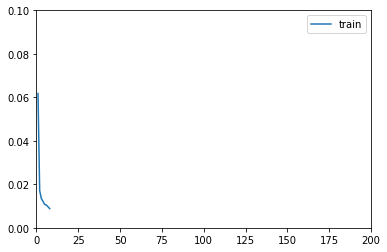

In [ ]:
history = nhat.train(200,alpha=0.5,beta=0.5,checkpoint_prefix="/content/drive/MyDrive/Pix2Pix-for-Semantic-Segmentation-of-Satellite-Images/checkpoint/ckpt_{score:.4f}.h5")

In [ ]:
sio.savemat('/content/drive/MyDrive/Pix2Pix-for-Semantic-Segmentation-of-Satellite-Images/__checkpoint/history.mat',history)

In [ ]:
nhat.model.load_weights('/content/drive/MyDrive/Pix2Pix-for-Semantic-Segmentation-of-Satellite-Images/__checkpoint/ckpt_0.8470.h5')

In [ ]:
#nhat.evaluateTest(test_dataset)

In [ ]:
for i in range(x_test.shape[0]):
  #y_pred = nhat.model(normalize(x_test[i:i+1],y_test[i:i+1]))
  y_pred = nhat.model(x_test[i:i+1])
  y_predShow = np.argmax(y_pred,axis = -1)
  plt.figure(i+1)
  plt.subplot(131),plt.imshow(x_test[i]),plt.title('image')
  plt.subplot(132),plt.imshow(y_predShow[0],cmap ='gray'),plt.title('predict')
  plt.subplot(133),plt.imshow(y_test[i,...,0],cmap='gray'),plt.title('groundtruth')
  plt.show()